In [14]:
'''Credits: Andrei Miroshnikov andrej.miroshnikow@gmail.com'''

#installs for EEG and fNIRS processing. uncomment if needed to install in Jupyter

# !pip install mne
# !pip install mne_nirs
# !pip install numpy
# !pip install matplotlib

In [23]:
import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import compress

import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair)
from mne import Epochs, events_from_annotations
%matplotlib auto

Using matplotlib backend: QtAgg


### The cell below scans a directory for all fNIRS data files and arranges their paths in lists. It's done for group analysis

In [16]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

fnirs_dir = r"C:\Users\Admin\Desktop\IMAGERY-FNIRS"

subfolders = fast_scandir(fnirs_dir)

subj_names = sorted([(i.split('\\')[-1]) for i in subfolders if len(i.split('\\')[-1])==2])
recordings_names = sorted([i for i in subfolders if '_' in i and '.' not in i])

In [24]:
filename = recordings_names[-1]
# filename = ... #insert the path to a folder\file were fNIRS data are stored


#there are several ways to read fNIRS data. 
# maybe for LUMO format there will be another option
raw_intensity = mne.io.read_raw_nirx(
    filename,
    verbose=True
)



raw_od = mne.preprocessing.nirs.optical_density(raw_intensity) #from row wavelength data
# raw_od.drop_channels(['S2_D4 760', 'S2_D4 850']) we had a non-existent channel
#if you have short channels, you can perform some regression to exclude skin bloodflow
raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od) #repairs movement artifacts
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR
raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

#filtering parameters are wery tricky. you may like to set your own filtering borders.
low_f_border, high_f_border = 0.02,0.25
h_trans_bandwidth, l_trans_bandwidth = 0.2, 0.02
raw_haemo = raw_haemo.filter(low_f_border, high_f_border,
                             h_trans_bandwidth=h_trans_bandwidth,
                             l_trans_bandwidth=l_trans_bandwidth)
#this is optional. it makes HbO and HbR to -correlate to a greater extent
raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

##############################################

Loading C:\Users\Admin\Desktop\IMAGERY-FNIRS\VL\VL_TS
Reading 0 ... 6940  =      0.000 ...   682.230 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.25 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.35 Hz)
- Filter length: 1679 samples (165.052 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:    0.0s finished


### This cell is about selecting a subgroup of channels. In our case, we wanted to select channels around C3 and C4 10-20 leads (corresponding locations are listed). So we end up having a pair of groups of ~20 long channels corresponding for each side's sensorimotor zone.

In [18]:
chnames = raw_haemo.ch_names


C3 = ['FC3', 'FCC5h', 'FCC3h', 'FCC1h', 'C5', 'C1', 'CCP5h', 'CCP3h']
C4 = ['FC4', 'FCC6h', 'FCC4h', 'FCC2h', 'C2', 'C6', 'CCP4h', 'CCP6h']

optodes_to_channels = {
                  'FC3':'D10',
                  'FC4':'D11',
                  'FTT7h':'D12',
                  'FCC5h':'S9',
                  'FCC3h':'D13',
                  'FCC1h':'S10',
                  'FCC2h':'S11',
                  'FCC4h':'D14',
                  'FCC6h':'S12',
                  'FTT8h':'D15',
                  'C5':'S13',
                  'C1':'D16',
                  'C2':'D17',
                  'C6':'S14',
                  'TTP7h':'S15',
                  'CCP5h':'D18',
                  'CCP3h':'S16',
                  'CCP1h':'D19',
                  'CCP2h':'D20',
                  'CCP4h':'S17',
                  'CCP6h':'D21',
                  'TTP8h':'S18'
                  }


C3_channels = [optodes_to_channels[i] for i in C3]
C4_channels = [optodes_to_channels[i] for i in C4]

def chans_of_interest(optodes_of_interest):
    chans_hbo = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbo' in x]
    chans_hbr = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbr' in x]

    return chans_hbo, chans_hbr

C3_chans_of_interest_hbo, C3_chans_of_interest_hbr = chans_of_interest(C3_channels)
C4_chans_of_interest_hbo, C4_chans_of_interest_hbr = chans_of_interest(C4_channels)

###############################################

In [19]:
def clean_epochs(raw_haemo, events, ids, tmin=0, tmax=14):
    '''This functions takes raw_haemo recording, events and ids, 
    splits them into epochs according to events timings and ids. 
    There is and inside function epoch_rejector, which recjects top and low 10% of
    deviant epochs in each epochs' type ''' 

    tmin, tmax = tmin, tmax
    epochs = mne.Epochs(
                        raw_haemo,
                        events,
                        event_id=ids,
                        baseline=None,
                        tmin=tmin,
                        tmax=tmax,
                        preload=True,
                        verbose=False,
                        # picks=picks
                       )


    rest_epochs_raw = epochs["Rest"]
    smr_epochs_raw = epochs["Sensorimotor"]

    info = smr_epochs_raw.info
    chans = mne.io.pick.channel_indices_by_type(info)
    info_hbo = mne.pick_info(info,chans['hbo'])
    info_hbr = mne.pick_info(info,chans['hbr'])
    hbo_chnames = info_hbo.ch_names
    hbr_chanames = info_hbr.ch_names


    smr_epochs_data = smr_epochs_raw.get_data()
    rest_epochs_data = rest_epochs_raw.get_data()

    def epochs_rejector(epochs_data, criterion='median', 
                        time_limits = (40, 120),
                        lower=0.10, upper=0.90):

        epochs_data = epochs_data[:, :, time_limits[0]:time_limits[1]]

        if criterion == 'median':

            median = np.median(epochs_data, axis=1)
            median = np.median(median, axis=1)
            lower_quantile = np.quantile(median, lower)
            upper_quantile = np.quantile(median, upper)

            reject_bool_negative = median < lower_quantile
            reject_bool_positive = median > upper_quantile

            reject_bool = np.logical_or(reject_bool_negative, reject_bool_positive)

        return reject_bool

    smr_reject_bool = epochs_rejector(smr_epochs_data)
    rest_reject_bool = epochs_rejector(rest_epochs_data)

    smr_epochs = smr_epochs_raw.drop(smr_reject_bool)
    rest_epochs = rest_epochs_raw.drop(rest_reject_bool)

    evoked_smr = smr_epochs.average()
    evoked_rest = rest_epochs.average()

    return smr_epochs, rest_epochs, evoked_smr, evoked_rest

In [22]:
rec__ = [recordings_names[-1]]

for recording in rec__:
    

    raw_intensity = mne.io.read_raw_nirx(
        recording,
        verbose=True
    )

    splitting_slash = '\\'
    CONDITION = recording.split(splitting_slash)[-1].split('_')[-1]
    SUBJECT = recording.split(splitting_slash)[-1].split('_')[0]
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
    raw_od.drop_channels(['S2_D4 760', 'S2_D4 850'])
    raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)
    raw_haemo = raw_haemo.filter(0.02, 0.25,
                                 h_trans_bandwidth=0.2,
                                 l_trans_bandwidth=0.02)
    raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

    channel_std = np.std(raw_haemo.get_data(), axis=(1))

    # Define a threshold for standard deviation
    threshold = np.quantile(channel_std, 0.99)

    # Identify outlier channels
    outlier_channels = list(np.where(channel_std > threshold)[0])

    channels_to_remove = [raw_haemo.ch_names[i].split(' ')[0] for i in outlier_channels]
    channels_to_remove_hbo = [i+' hbo' for i in channels_to_remove]
    channels_to_remove_hbr = [i+' hbr' for i in channels_to_remove]

    channels_to_remove = sorted(channels_to_remove_hbo + channels_to_remove_hbr)

    raw_haemo.info['bads'] = channels_to_remove
    print(channels_to_remove)
    raw_haemo = raw_haemo.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))

    ####################################################    
    events, ids = mne.events_from_annotations(raw_haemo)
    ids["Rest"] = 2
    ids["Sensorimotor"] = 1
    try:
        ids.pop("2.0")
        ids.pop("1.0")
    except:
        ids.pop("2")
        ids.pop("1")
        
    ####################################################
    smr_epochs, rest_epochs, _, _ = clean_epochs(raw_haemo, events=events, ids=ids)
    
    
    ####################################################
    picks_hbo_left, picks_hbr_left = C3_chans_of_interest_hbo, C3_chans_of_interest_hbr
    picks_hbo_right, picks_hbr_right = C4_chans_of_interest_hbo, C4_chans_of_interest_hbr


    evoked_dict_left = {f'{CONDITION}/HbO': smr_epochs.copy().average(picks=picks_hbo_left),
                   f'{CONDITION}/HbR': smr_epochs.copy().average(picks=picks_hbr_left),
                   'Rest/HbO': rest_epochs.copy().average(picks=picks_hbo_left),
                   'Rest/HbR': rest_epochs.copy().average(picks=picks_hbr_left)}

    evoked_dict_right = {f'{CONDITION}/HbO': smr_epochs.copy().average(picks=picks_hbo_right),
                   f'{CONDITION}/HbR': smr_epochs.copy().average(picks=picks_hbr_right),
                   'Rest/HbO': rest_epochs.copy().average(picks=picks_hbo_right),
                   'Rest/HbR': rest_epochs.copy().average(picks=picks_hbr_right)}

    # Rename channels until the encoding of frequency in ch_name is fixed
    for condition in evoked_dict_left:
        evoked_dict_left[condition].rename_channels(lambda x: x[:-4])

    for condition in evoked_dict_right:
        evoked_dict_right[condition].rename_channels(lambda x: x[:-4])

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    color_dict = dict(HbO='#AA3377', HbR='b')
    styles_dict = dict(Rest=dict(linestyle='dashed'))


    y_min = min(evoked_dict_left[f'{CONDITION}/HbO'].data.min(),
                evoked_dict_right[f'{CONDITION}/HbO'].data.min(),()) * 10**6
    y_max = max(evoked_dict_left[f'{CONDITION}/HbO'].data.max(),
                evoked_dict_right[f'{CONDITION}/HbO'].data.max(),()) * 10**6
    ylim = {'hbo':[y_min, y_max],
                'hbr':[y_min, y_max]}

    left_plot = mne.viz.plot_compare_evokeds(evoked_dict_left,
                                             combine="mean",
                                             ci=0.95,
                                             colors=color_dict,
                                             styles=styles_dict,
                                             title=f'{CONDITION} and Rest trials LEFT hemisphere\nSubject {SUBJECT}',
                                             axes=axes[0],
                                             ylim=ylim,
                                             truncate_xaxis=False)  # Use the first subplot axes
    right_plot = mne.viz.plot_compare_evokeds(evoked_dict_right,
                                               combine="mean",
                                               ci=0.95,
                                               colors=color_dict,
                                               styles=styles_dict,
                                               title=f'{CONDITION} and Rest trials RIGHT hemisphere\nSubject {SUBJECT}',
                                               axes=axes[1],
                                               ylim=ylim,
                                               truncate_xaxis=False)  # Use the second subplot axes

    target_fig_curves = right_plot[0]
    
    times = np.arange(2, 14, 2)
    topomap_args = dict(extrapolate='local')

    # Plot topomaps for smr_epochs
    smr_evoked = smr_epochs.average(picks='hbo')
    smr_fig = smr_evoked.plot_topomap(times=times, show=False, **topomap_args)

    # Plot topomaps for rest_epochs
    rest_evoked = rest_epochs.average(picks='hbo')
    rest_fig = rest_evoked.plot_topomap(times=times, show=False, **topomap_args)

    vmin = min(smr_evoked.data.min(), rest_evoked.data.min())*10**6
    vmax = max(smr_evoked.data.max(), rest_evoked.data.max())*10**6
    vlim = (vmin, vmax)

    # Create a figure to contain both topomap plots
    fig, axes = plt.subplots(2, len(times)+1, figsize=(12, 6))

    # Loop through times and plot the topomaps for smr_epochs and rest_epochs
    smr_evoked.plot_topomap(times, axes=axes[0, :],
                            # title=f'SMR {time} ms',
                            colorbar=True,
                            show=False,
                            vlim=vlim,
                            **topomap_args)
    rest_evoked.plot_topomap(times, axes=axes[1, :],
                            #  title=f'Rest {time} ms',
                              show=False,
                              colorbar=True,
                              vlim=vlim,
                              **topomap_args)
    # Show the figure
    plt.show()


Loading C:\Users\Admin\Desktop\IMAGERY-FNIRS\VL\VL_TS
Reading 0 ... 6940  =      0.000 ...   682.230 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.25 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.35 Hz)
- Filter length: 1679 samples (165.052 s)

['S12_D11 hbo', 'S12_D11 hbr', 'S29_D24 hbo', 'S29_D24 hbo', 'S29_D24 hbr', 'S29_D24 hbr']
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Used Annotations descriptions: ['1.0', '2.0']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
C:\Users\Admin\AppData\Local\Temp\ipykernel_1300\4210614583.py:43: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_haemo = raw_haemo.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Dropped 4 epochs: 4, 5, 9, 17
Dropped 4 epochs: 0, 2, 9, 15
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining ch

C:\Users\Admin\AppData\Local\Temp\ipykernel_1300\4210614583.py:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_min = min(evoked_dict_left[f'{CONDITION}/HbO'].data.min(),
C:\Users\Admin\AppData\Local\Temp\ipykernel_1300\4210614583.py:90: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_max = max(evoked_dict_left[f'{CONDITION}/HbO'].data.max(),


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


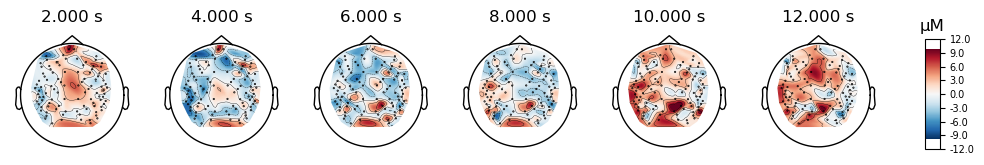

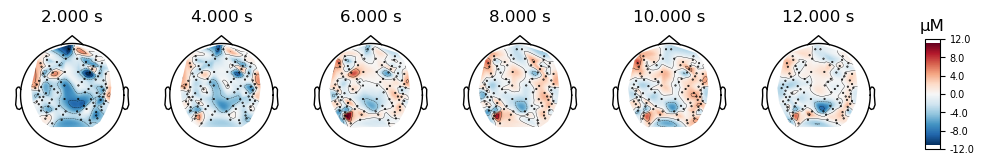

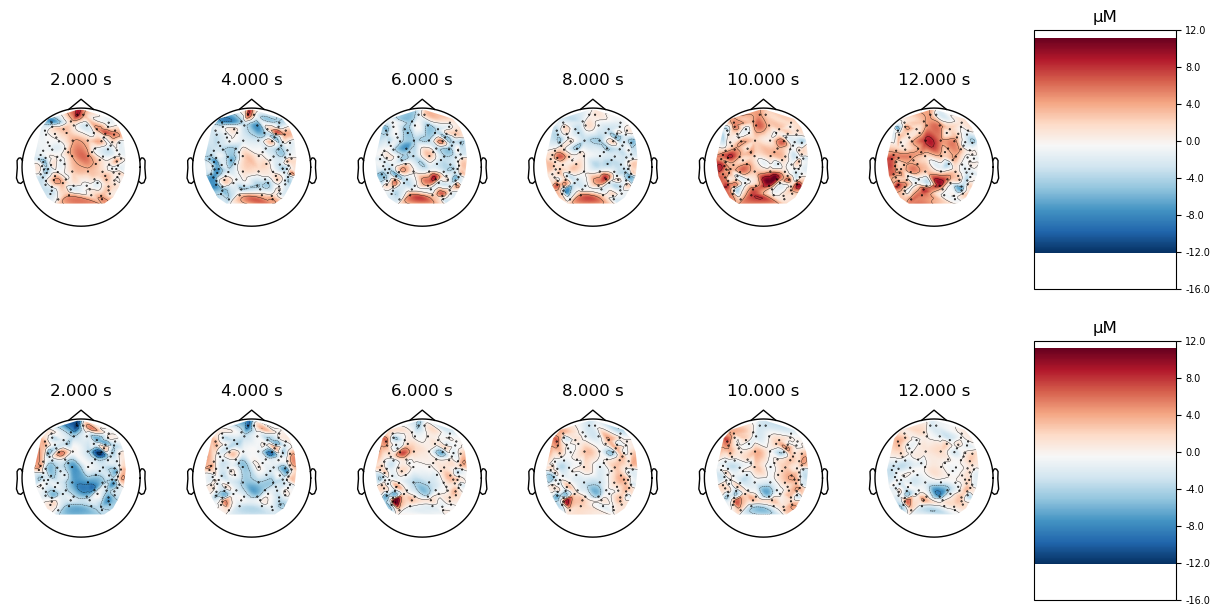

In [20]:
times = np.arange(2, 14, 2)
topomap_args = dict(extrapolate='local')

# Plot topomaps for smr_epochs
smr_evoked = smr_epochs_cleaned.average(picks='hbo')
smr_fig = smr_evoked.plot_topomap(times=times, show=False, **topomap_args)

# Plot topomaps for rest_epochs
rest_evoked = rest_epochs_cleaned.average(picks='hbo')
rest_fig = rest_evoked.plot_topomap(times=times, show=False, **topomap_args)

vmin = min(smr_evoked.data.min(), rest_evoked.data.min())*10**6
vmax = max(smr_evoked.data.max(), rest_evoked.data.max())*10**6
vlim = (vmin, vmax)

# Create a figure to contain both topomap plots
fig, axes = plt.subplots(2, len(times)+1, figsize=(12, 6))

# Loop through times and plot the topomaps for smr_epochs and rest_epochs
smr_fig = smr_evoked.plot_topomap(times, axes=axes[0, :],
                        # title=f'SMR {time} ms',
                        colorbar=True,
                        show=False,
                        vlim=vlim,
                        **topomap_args)
rest_fig = rest_evoked.plot_topomap(times, axes=axes[1, :],
                        #  title=f'Rest {time} ms',
                          show=False,
                          colorbar=True,
                          vlim=vlim,
                          **topomap_args)
# Show the figure
plt.show()


In [ ]:
channel_std = np.std(smr_epochs.get_data(), axis=(0, 2))

# Define a threshold for standard deviation
threshold = 1*10**-5  # Adjust this threshold based on your data

# Identify outlier channels
outlier_channels = list(np.where(channel_std > threshold)[0])

# Create a list of channels to remove
channels_to_remove = [smr_epochs.ch_names[i] for i in outlier_channels]

# Remove outlier channels from the Epochs object
smr_epochs_cleaned = smr_epochs.copy().drop_channels(channels_to_remove)
rest_epochs_cleaned = rest_epochs.copy().drop_channels(channels_to_remove)

In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define your times of interest
times = np.arange(2, 14, 2)
haemo_picks = "hbo"
REST = CONDITION + "_Rest"
topomap_args = dict(extrapolate='local')

# Plot topomaps for smr_epochs
smr_evoked = smr_epochs_cleaned.average(picks=haemo_picks)
smr_fig = smr_evoked.plot_topomap(times=times, show=False, **topomap_args)

# Plot topomaps for rest_epochs
rest_evoked = rest_epochs_cleaned.average(picks=haemo_picks)
rest_fig = rest_evoked.plot_topomap(times=times, show=False, **topomap_args)

vmin = min(smr_evoked.data.min(), rest_evoked.data.min())*10**6
vmax = max(smr_evoked.data.max(), rest_evoked.data.max())*10**6
vlim = (vmin, vmax)

# Create a figure to contain both topomap plots
# fig, axes = plt.subplots(2, len(times)+1, figsize=(14, 12))

# Loop through times and plot the topomaps for smr_epochs and rest_epochs
smr_image = smr_evoked.plot_topomap(times,
                                    size=4,
                                    colorbar=True,
                                    show=False,
                                    vlim=vlim,
                                    **topomap_args)
rest_image = rest_evoked.plot_topomap(times,
                                      size=4,
                                      show=False,
                                      colorbar=True,
                                      vlim=vlim,
                                      **topomap_args)

smr_image.suptitle(f"{SUBJECT} {haemo_picks} distribution in {CONDITION}", fontsize=20)
rest_image.suptitle(f"{SUBJECT} {haemo_picks} distribution in {REST}", fontsize=20)
# smr_image.set_tight_layout(True)
# rest_image.set_tight_layout(True)




# Show the figure
plt.show()

In [ ]:
smr_evoked = smr_epochs.copy().average()
data_smr = smr_evoked.get_data()
mode = st.mode(np.argmax(data_smr, axis=0)[4:12])[0][0]
top_channel_C3_hbo = smr_evoked.ch_names[mode]
top_channel_C3_hbr = top_channel_C3_hbo.replace('o', 'r')
top_channel_C3 = top_channel_C3_hbo.removesuffix(' hbo')